In [1]:
#pip install bambi

# Importing Libraries and Loading Data

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import bambi as bmb
from bambi import Model
import arviz as az
# to ignore warnings:
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("Advertising.csv")

In [4]:
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [5]:
df = df.iloc[:,1:len(df)]

In [6]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [7]:
df.shape

(200, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


## Variable Correlations with Sales

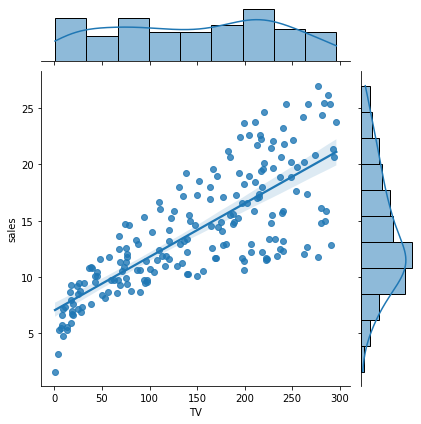

In [10]:
sns.jointplot(x = "TV", y = "sales", data = df, kind = "reg");

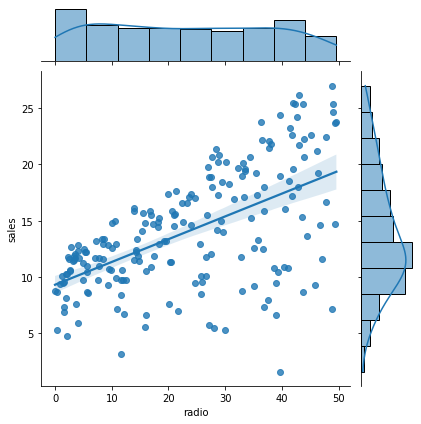

In [11]:
sns.jointplot(x = "radio", y = "sales", data = df, kind = "reg");

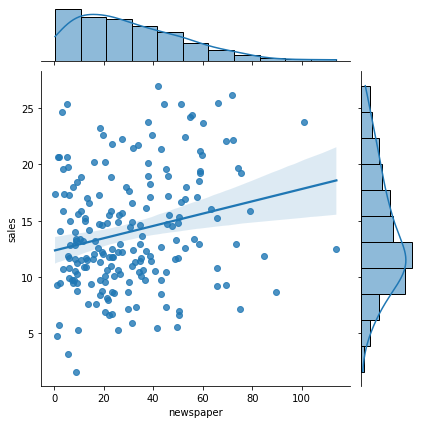

In [12]:
sns.jointplot(x = "newspaper", y = "sales", data = df, kind = "reg");

In [13]:
df.corr()['sales'].sort_values()

newspaper    0.228299
radio        0.576223
TV           0.782224
sales        1.000000
Name: sales, dtype: float64

# Modeling

In [14]:
y = df[["sales"]]

In [15]:
X = df[["TV","radio","newspaper"]]

In [16]:
 # Spliting the train data
 X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                        test_size = 0.25,
                                                        random_state=42)

In [17]:
X_train.head()

,TV,radio,newspaper,sales
114,78.2,46.8,34.5,14.6
173,168.4,7.1,12.8,11.7
5,8.7,48.9,75.0,7.2
126,7.8,38.9,50.6,6.6
117,76.4,0.8,14.8,9.4


In [18]:
print(X_train.shape)
print(X_test.shape)

(150, 4)
(50, 4)


In [19]:
# Formula for Bayesian Linear Regression 
formula = 'sales ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[:-1]])
formula

'sales ~ TV + radio + newspaper'

## Bayesian model with Bambi 

In [22]:
# Initialize the model
model = Model(formula, X_train)

# Set a custom prior on group specific factor variances—just for illustration
group_specific_sd = bmb.Prior("HalfNormal", sigma=10)
group_specific_prior = bmb.Prior("Normal", mu=0, sigma=group_specific_sd)
model.set_priors(group_specific=group_specific_prior)

# Fit the model, drawing 1,000 MCMC draws per chain
results = model.fit(draws=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sales_sigma, newspaper, radio, TV, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [23]:
model

Formula: sales ~ TV + radio + newspaper
Family name: Gaussian
Link: identity
Observations: 150
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 14.3047, sigma: 38.6543)
    TV ~ Normal(mu: 0.0, sigma: 0.1525)
    radio ~ Normal(mu: 0.0, sigma: 0.8708)
    newspaper ~ Normal(mu: 0.0, sigma: 0.6261)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 5.175)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### The prior distributions for all parameters 

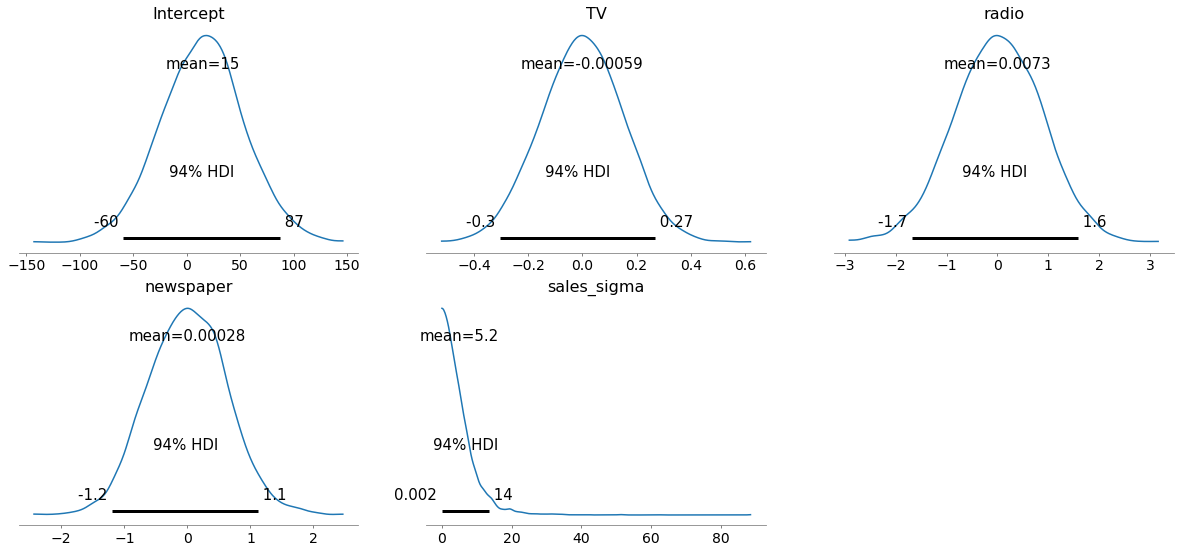

In [34]:
model.plot_priors();

### The posterior distributions and traces for all parameters

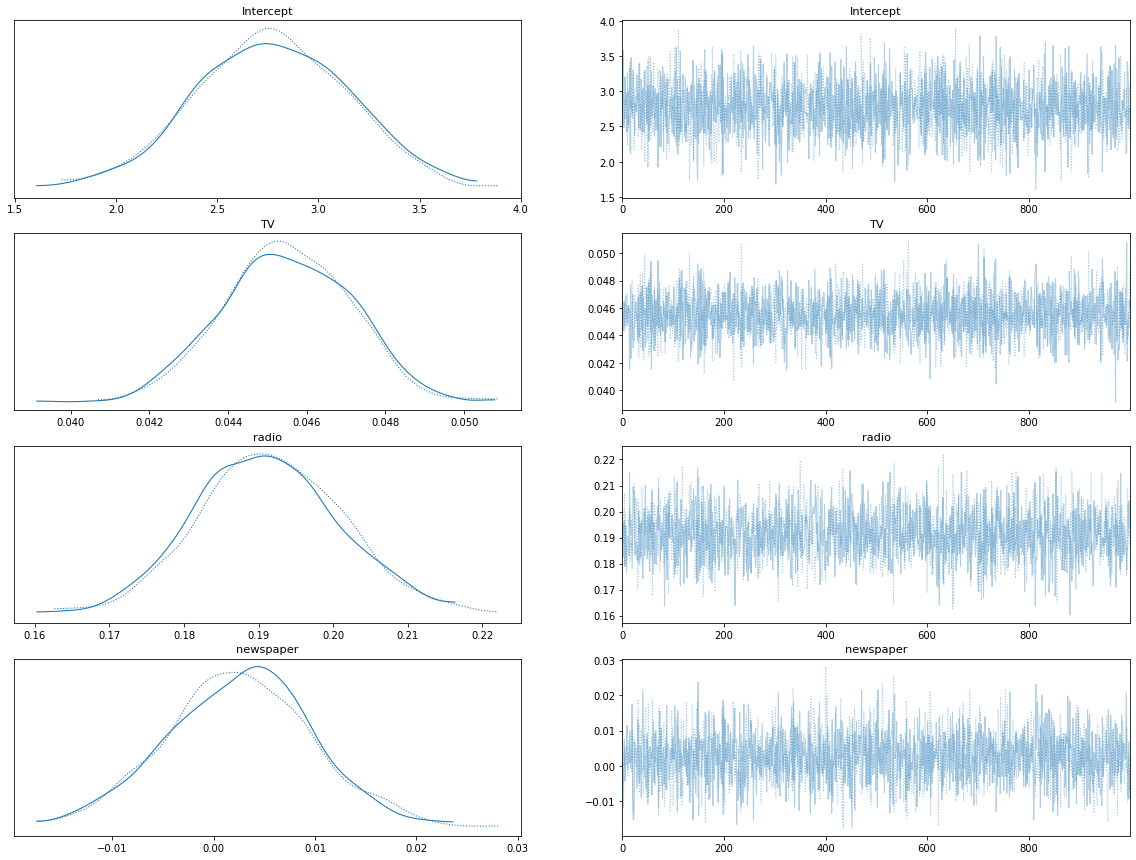

In [36]:
az.plot_trace(
    results,
    var_names=["Intercept", "TV", "radio", "newspaper"],
    compact=True, figsize=(20, 15)
);

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

### The numerical summary of the results display shows us the mean, standard deviation, and 94% highest density interval for the posterior. 

In [26]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.768,0.378,2.083,3.507,0.006,0.004,3617.0,1789.0,1.0
TV,0.045,0.002,0.042,0.048,0.000,0.000,2999.0,1529.0,1.0
radio,0.191,0.010,0.173,0.210,0.000,0.000,2013.0,1556.0,1.0
newspaper,0.003,0.007,-0.010,0.017,0.000,0.000,2598.0,1782.0,1.0
sales_sigma,1.702,0.099,1.518,1.882,0.002,0.001,3076.0,1612.0,1.0
